# Pandas DataFrame Concatenation and Calculations

In [111]:
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
RAW_DATA_DIR = Path('data', 'financial', 'raw', 'companies')
WRANGLED_DATA_DIR = Path('data', 'financial', 'wrangled')
WRANGLED_DATA_DIR.mkdir(exist_ok=True, parents=True)

# Concatenating

In [112]:
xlist = []
for fname in RAW_DATA_DIR.glob('*.csv'):
    xf = pd.read_csv(fname, parse_dates=['Date'])
    ticker = fname.stem
    xf['company'] = ticker
    # rearrange the columns
    headers = ['company'] + list( xf.columns[:-1])    
    xf =  xf[headers]
    xlist.append(xf)
    
# Concatenate    
daily_df = pd.concat(xlist)



In [113]:
# write to disk
output_fname = WRANGLED_DATA_DIR.joinpath('tech-companies-daily.csv')
daily_df.to_csv(str(output_fname), index=False)

# Calculations


In [114]:
# new dataframe, fewer columns
chdf = daily_df[['company', 'Date', 'Volume', 'Close', 'Adj Close']]
# rename the columns
chdf.columns = ['company', 'date', 'volume', 'close', 'adj_close']
# sort by company name, then chronological order
chdf = chdf.sort_values(['company', 'date'])


# add a new column
chdf['adj_close_pct_change'] = 0.0
chdf['ipo_valuation_pct_change'] = 0.0
chdf['days_since_ipo'] = 0

# populate it iteratively
# derive ticker names from the existing dataset (yeah, it's wasteful)
tickers = chdf['company'].unique()
for t in tickers:
    tdf = chdf[chdf.company == t]
    # calculate pct change over day    
    pctchanges = tdf['adj_close'].pct_change() * 100
    chdf.ix[chdf.company == t, 'adj_close_pct_change'] = pctchanges

    # get first day...assumes chdf is still sortee chronologically
    firstrow = tdf.iloc[0]
    
    # calculate days since ipo
    ipodays = (tdf['date'] - firstrow['date']).dt.days
    chdf.ix[chdf.company == t, 'days_since_ipo'] = ipodays

    # calculate ipo valuation ratio 
    ipoval = firstrow['adj_close']
    ipodeltas = 100 * (tdf['adj_close'] - ipoval) / ipoval
    chdf.ix[chdf.company == t, 'ipo_valuation_pct_change'] = ipodeltas
    
# round the numbers
chdf = chdf.round({'close': 2, 'adj_close': 2, 'adj_close_pct_change': 2, 'ipo_valuation_pct_change': 2})


In [115]:
# save to disk
output_fname = WRANGLED_DATA_DIR.joinpath('tech-companies-daily-changes.csv')
chdf.to_csv(str(output_fname), index=False)


# Visualize

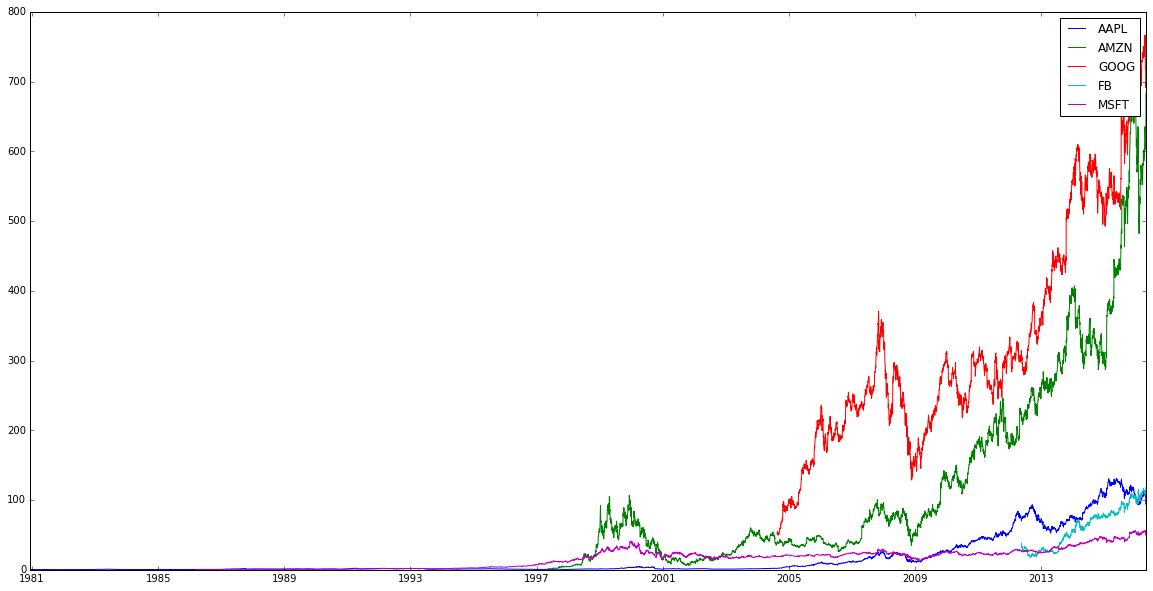

In [116]:
# history of stock price
tickers = ['AAPL', 'AMZN', 'GOOG', 'FB', 'MSFT',]
fig, ax = plt.subplots(figsize=(20, 10))
for t in tickers:
    tdf = chdf[chdf.company == t]
    ax.plot(tdf.date, tdf.adj_close)

ax.legend(tickers);

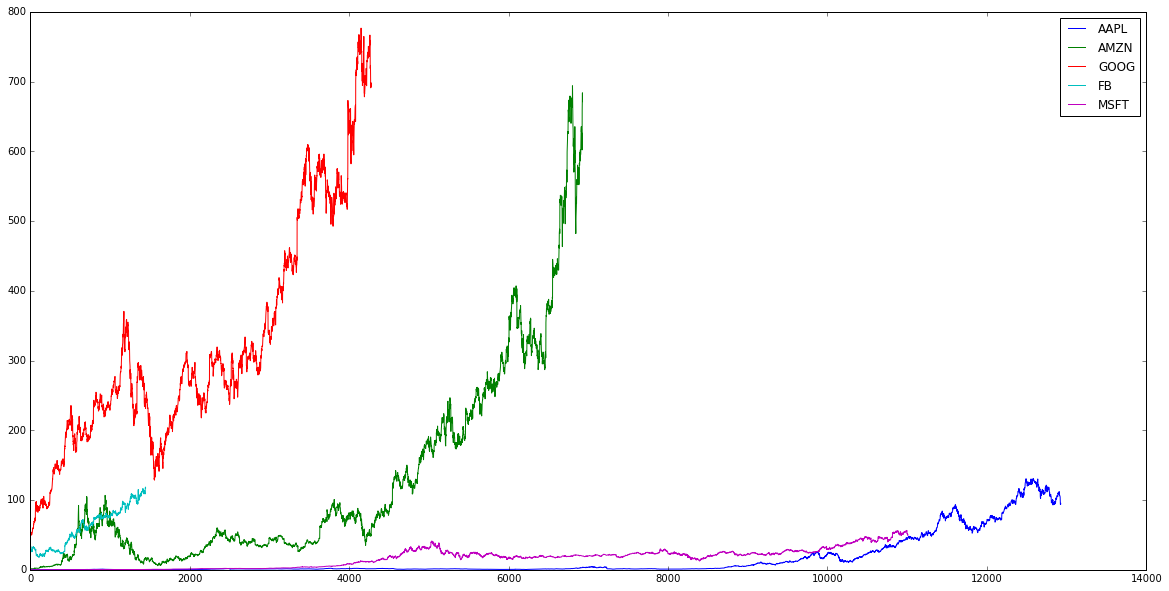

In [117]:
# by days since IPO
fig, ax = plt.subplots(figsize=(20, 10))
for t in tickers:
    tdf = chdf[chdf.company == t]
    ax.plot(tdf.days_since_ipo, tdf.adj_close)

ax.legend(tickers);

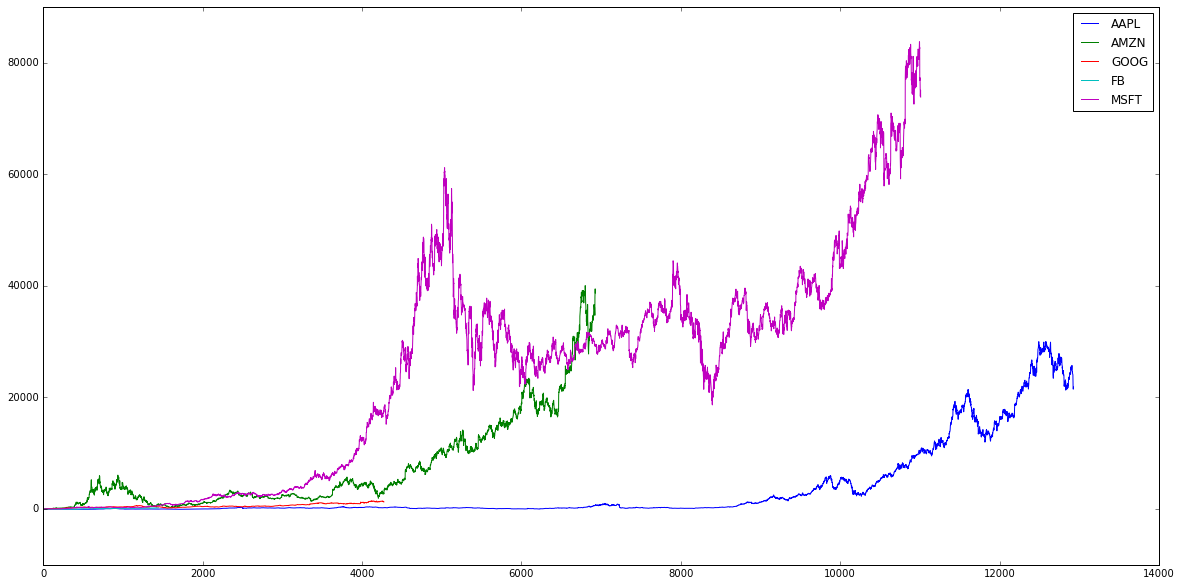

In [118]:
fig, ax = plt.subplots(figsize=(20, 10))
for t in tickers:
    tdf = chdf[chdf.company == t]
    ax.plot(tdf.days_since_ipo, tdf.ipo_valuation_pct_change)

ax.legend(tickers);

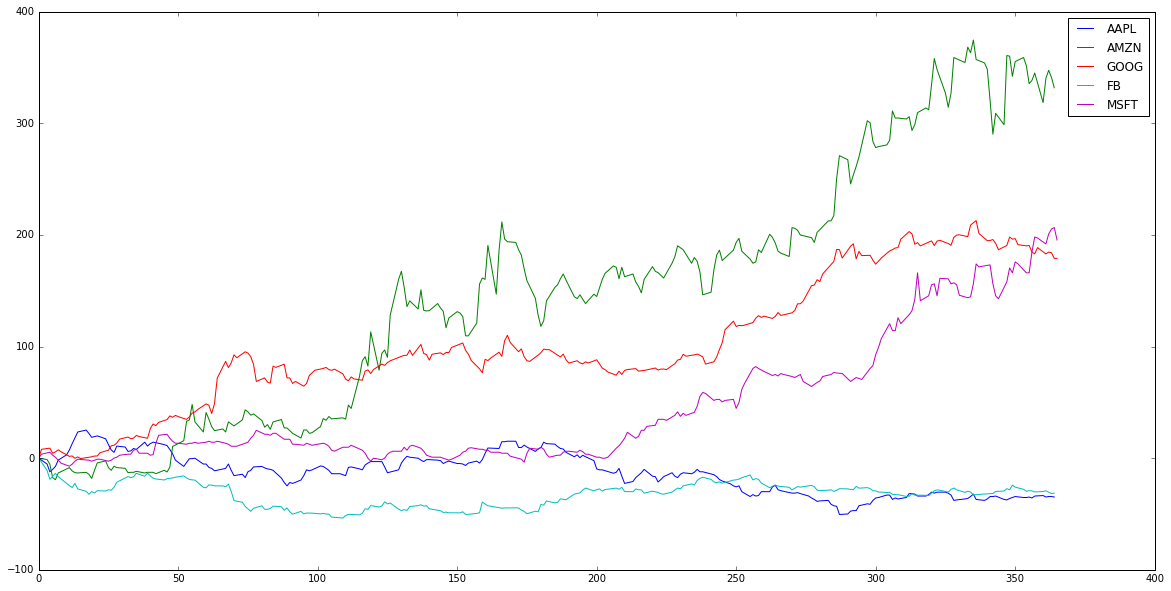

In [119]:
fig, ax = plt.subplots(figsize=(20, 10))
for t in tickers:
    tdf = chdf[(chdf.company == t) & (chdf.days_since_ipo <= 365)]
    ax.plot(tdf.days_since_ipo, tdf.ipo_valuation_pct_change)

ax.legend(tickers);